<a href="https://colab.research.google.com/github/carol1521/2-tier-Argumentation-Framework/blob/main/Yan_evidence_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidences_detection

## Reading_data

In [ ]:
!pip install scikit-plot

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import string
import nltk
import gensim
import os
import warnings
import matplotlib.pyplot as plt
import scikitplot as skplt
import networkx as nx
 
from nltk.tokenize.punkt import PunktSentenceTokenizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten,TimeDistributed,LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

%notebook inline
warnings.filterwarnings("ignore")
root = os.getcwd() + '/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0'
print(root)

/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0


In [ ]:
def read_file(filename):
    data = []
    with open(filename, 'r') as f:
        text = f.read().split('\n')
        for parag in text:
            if len(parag) >2:
                data = data + [a for a in parag.split('. ') if len(a)>0]
                
    return data

In [ ]:
articles = dict()
for subdir, dirs, files in os.walk('/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/wiki12_articles'):
 

    for file in files:
        #if file[-3:] == 'txt' and file[:5] == 'clean':
        filename = os.path.join(subdir, file)
        print(filename)
        articles[file] = read_file(filename)


In [ ]:
!pip install xlrd

In [ ]:
evidence_trainDF = pd.read_csv("/content/drive/MyDrive/Yan/IBMDebaterEvidenceSentences 3/train.csv")
evidence_trainDF[:1].T

,0
topic,We should limit executive compensation
the concept of the topic,executive compensation
candidate,A say on pay - a non-binding vote of the gener...
candidate masked,A say on pay - a non-binding vote of the gener...
label,0
wikipedia article name,Executive pay
wikipedia url,https://en.wikipedia.org/wiki/Executive_pay


In [ ]:
evidence_testDF = pd.read_excel("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/2014_7_18_ibm_CDE(1)data.xlsx")
article_paths = set(evidence_testDF['Article'])
print(article_paths)

In [ ]:
evidence_testDF[:1].T

,0
Topic,the sale of violent video games to minors
Article,Video_game_controversies
Claim,exposure to violent video games causes at leas...
CDE,The most recent large scale meta-anlysis-- exa...
Type 1,STUDY
Type 2,NaN
Unnamed: 6,NaN


In [ ]:
def textrank(sentences):
#     sentence_tokenizer = PunktSentenceTokenizer()
#     sentences = sentence_tokenizer.tokenize(document)
 
    bow_matrix = CountVectorizer().fit_transform(sentences)
    normalized = TfidfTransformer().fit_transform(bow_matrix)
 
    similarity_graph = normalized * normalized.T
 
    nx_graph = nx.from_scipy_sparse_matrix(similarity_graph)
    scores = nx.pagerank(nx_graph)
    
    return dict((s, scores[i]) for i,s in enumerate(sentences))

In [ ]:
articles_tags_test = []
#articles_sent_length = []
sentences_test = []
topics_test = []
#article_locs = []
#article_rank = []


In [ ]:

for a in article_paths:
    article_name = a.split('/')[-1]
    print(article_name)
    #print(articles)
    
    sents = articles[article_name]
    #rank_dict = textrank(sents)
    evidences = list(evidence_testDF[evidence_testDF['Article'] == a]['CDE'])
    topic = list(evidence_testDF[evidence_testDF['Article'] == a]['Topic'])[0]
    tags = []
    #sent_length = []
    #locs = []
    #rank = []
    
    for i, sent in enumerate(sents):
        '''
        # get normalized location
        locs.append(i+1/float(len(sents)))
        
        # get text rank score
        r = rank_dict[sent]
        rank.append(r)
        
        # get sent length
        tokens = [a for a in sent.split() if a != '']
        sent_length.append(len(tokens))
        '''
    
        topics_test.append(topic)
        flag = False
        for evidence in evidences:
            if evidence in sent:
                tags.append(1)
                evidences.remove(evidence)
                flag = True
                break
        if not flag:
            tags.append(0)  
    
    sentences_test.append(sents)
    articles_tags_test.append(tags)
    #article_locs.append(locs)
    #articles_sent_length.append(sent_length)
    #article_rank.append(rank)

In [ ]:
d_train = {'sentences': evidence_trainDF['candidate'],
           'topic': evidence_trainDF['topic'],
           'label': evidence_trainDF['label']
           }
df_train = pd.DataFrame(d_train)           

In [ ]:
df_train.shape

(4065, 3)

In [ ]:
d_test = {'sentences': sum(sentences_test, []), 
     'topic': topics_test, 
     'label': sum(articles_tags_test, [])}
df_test = pd.DataFrame(d_test)

In [ ]:
test_data = list(zip(sum(sentences_test, []), topics_test,\
                     sum(articles_tags_test, [])))

# sentence, topic, label

In [ ]:
def flatten(L):
    for item in L:
        try:
            yield from flatten(item)
        except TypeError:
            yield item

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#train set
len(df_train[df_train.label==0])
#len(df_train[df_train.label_train==1])

2566

In [ ]:
#test set 
#Separate majority and minority classes
df_majority = df_test[df_test.label==0]#not evidence
df_minority = df_test[df_test.label==1]#evidence

In [ ]:
len(df_majority)

17370

In [ ]:
len(df_minority)

404

In [ ]:
from sklearn.utils import resample

In [ ]:
len(df_majority_train)

2566

In [ ]:
len(df_minority_train)

1499

In [ ]:
#train
df_majority_train = df_train[df_train.label==0]#not evidence
df_minority_train = df_train[df_train.label==1]#evidence

In [ ]:
#train
NUMBER_PER_CLASS = 10000
# Upsample minority class
df_minority_upsampled_train = resample(df_minority_train, 
                                 replace=True,     # sample with replacement
                                 n_samples=NUMBER_PER_CLASS,    # to match majority class
                                 random_state=123) # reproducible results

df_majority_upsampled_train =  resample(df_majority_train, 
                                 replace=True,     # sample with replacement
                                 n_samples=NUMBER_PER_CLASS,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
df_upsampled_train = pd.concat([df_majority_upsampled_train, df_minority_upsampled_train])

In [ ]:
#test
NUMBER_PER_CLASS = 3500
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=NUMBER_PER_CLASS,    # to match majority class
                                 random_state=123) # reproducible results

df_majority_downsampled = df_majority.sample(NUMBER_PER_CLASS)


# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])

In [ ]:
#train, test = train_test_split(df_upsampled, test_size=0.2)
train = df_upsampled_train
test = df_upsampled

In [ ]:
train.shape

(20000, 3)

In [ ]:
#train_X.shape

(5600, 104)

## embedding

In [ ]:
def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
#         X = MyTokenizer().fit_transform(X)

        X = X.split(' ')
        emb = []
        for word in X:
            if word in self.word2vec.wv:
                emb.append(self.word2vec.wv[word])
            else:
                emb.append(np.zeros(self.dim))
        return np.mean(emb, axis = 0) #.reshape(1, 100)[0]
        
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
x = []
w2vec = get_word2vec(x, '/content/drive/MyDrive/Yan/w2vmodel')     #note, model is trained in 2_data_cleaning_word2vec script

Found /content/drive/MyDrive/Yan/w2vmodel


In [ ]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)

In [ ]:
def prepare_data(tmp, mean_embedding_vectorizer = mean_embedding_vectorizer):
    tmp['embed_sent'] = tmp['sentences'].apply(lambda x: mean_embedding_vectorizer.transform(x))
    tmp['embed_t']= tmp['topic'].apply(lambda x: mean_embedding_vectorizer.transform(x))
    tmp['similarity'] = tmp.apply(lambda x: cosine_similarity(x['embed_t'].reshape(1, -1),\
                                                              x['embed_sent'].reshape(1, -1))[0][0],1)
    
    tmp_y = list(tmp['label'])
    y = np.zeros((len(tmp_y), 2))
    for i, a in enumerate(tmp_y):
        y[i][a] = 1
    
    
    col = ['embed_sent', 'similarity']
    X = tmp[col].apply(lambda x: list(flatten(x)),1)
    X = np.array(list(X))
    
    return (X, y)

In [ ]:
train_X, train_y = prepare_data(train)
test_X, test_y = prepare_data(test)

## Model

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
#history = best_model.fit(train_X, train_y, validation_split=0.3, epochs=10, verbose=0)

# evaluate the model
#loss,accuracy, f1_score, precision, recall = best_model.evaluate(test_X, test_y, verbose=0)



In [ ]:
def model_evaluation_plt(model, test_X, test):
    res = model.predict(test_X)
    y_pred = res.argmax(1)
    y_true = list(test['label'])
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    #f1 = f1_m(y_true, y_pred)
    #print(f1)
    tensor_true, tensor_pred = K.variable(y_true), K.variable(y_pred)
    f1 = K.get_value(f1_m(tensor_true, tensor_pred))
    precision = K.get_value(precision_m(tensor_true, tensor_pred))
    recall = K.get_value(recall_m (tensor_true, tensor_pred))
    accuracy= model.evaluate(test_X, test_y, verbose=0)
    print('f1 score:',f1)
    print('precision :',precision)
    print('recall:',recall)
    print('accuracy:',accuracy[1])

### model_1_Feedforward neural network

In [ ]:
def wrapper(name = 'm', w = 1, n_hidden = 1, layer_width = 128, activ_func = 'tanh', input_dim = 101):
    
    path =  name
    callbacks = [
    EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
    ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
                                    save_best_only= True, save_weights_only=False, mode='max', period=1),]
    
    model = Sequential() 
    
    if activ_func == 'identity':
        activ_func = None
    
    # set number of hidden layer
    for i in range(n_hidden):
        model.add(Dense(units= layer_width, activation= activ_func, input_dim= input_dim)) 
    
    # make sure input_dim is initiated if there's no hidden layer
    if n_hidden == 0:
        input_dim = input_dim
    else:
        input_dim = layer_width
        
    model.add(Dense(2, activation='softmax', input_dim = input_dim)) 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(train_X, train_y, batch_size=32, epochs=50, verbose=0,\
        callbacks=callbacks) 

    score = model.evaluate(test_X, test_y, verbose= 0)
    print('Accuracy on test:', score[1])
#     model_evaluation(model, test_X, test)
    return (model,score[1])


In [ ]:
name = 'nn_default.h5'
m = wrapper(name)
# model = load_model('my_model.h5')


In [ ]:
model_list = []
acc_list = []
for n_hidden in range(1,4):
    for i in [256,512, 1024]:
        for f in ['identity', 'tanh', 'relu', 'sigmoid']:
            print('Number of hidden layers:', n_hidden)
            print('Layer width:', i)
            print('Activation function:', f)
            
            m, s = wrapper(n_hidden = n_hidden, layer_width = i, activ_func = f)
            model_list.append(m)
            acc_list.append(s)
            print('-'*28)


In [ ]:
best_finalE = model_list[acc_list.index(max(acc_list))]# 

In [ ]:
model = best_finalE

model.summary()
print("##Number of layers", len(model.layers))# Number of layers = n_hidden + 1(output layer)
for layer in model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)

f1 score: 0.55561006
precision : 0.65105563
recall: 0.48457143
accuracy: 0.6124285459518433


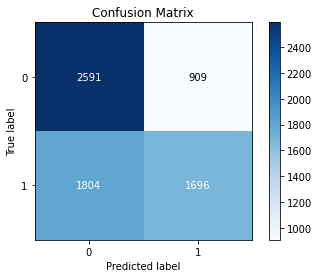

In [ ]:
#best_score = best_model.evaluate(test_X, test_y, verbose= 0)
#print(len(best_score))
#print('Accuracy on test:', best_score[2])

#model_evaluation_plt(best_finalE, test_X, test)
model_evaluation_plt(modelE_1, test_X, test)

In [ ]:
!mkdir -p saved_model
best_finalE.save('/content/drive/MyDrive/Yan/saved_model/best_finalE')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yan/saved_model/best_finalE/assets


In [ ]:
modelE_1 = tf.keras.models.load_model('/content/drive/MyDrive/Yan/saved_model/best_finalE')
predicts=modelE_1.predict(test_X)
predictions=predicts.argmax(1)

In [ ]:
model = modelE_1
model.summary()
print("##Number of layers", len(model.layers))# Number of layers = n_hidden + 1(output layer)
for layer in model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 256)               26112     
                                                                 
 dense_67 (Dense)            (None, 256)               65792     
                                                                 
 dense_68 (Dense)            (None, 256)               65792     
                                                                 
 dense_69 (Dense)            (None, 2)                 514       
                                                                 
Total params: 158,210
Trainable params: 158,210
Non-trainable params: 0
_________________________________________________________________
##Number of layers 4
dense_66/kernel:0 (101, 256)
dense_66/bias:0 (256,)
dense_67/kernel:0 (256, 256)
dense_67/bias:0 (256,)
dense_68/kernel:0 (256, 256)
dense_68/bias:0 (256,)
de

In [ ]:
predicted_result_e = {}
predicted_result_e['result'] = []
# predict_eval = clf1.predict(x_test).tolist()

for evidence, predicted_label in zip(test['sentences'], predictions):
    if predicted_label == 1:
        predicted_result_e['result'].append({
            "predicted_evidences": evidence,
            "predicted_label": predicted_label
        })

In [ ]:
!pip install xlsxwriter

In [ ]:
data = predicted_result_e['result']
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_result_e.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
#Only predict true
predicted_true_e = {}
predicted_true_e['true_result'] = []
y_true = list(test['label'])
for evidence, predicted_label, truth in zip(test['sentences'], predictions, y_true):
    if predicted_label == 1 and truth == 1:
        predicted_true_e['true_result'].append({
            "predicted_evidences": evidence,
            "predicted_label": predicted_label,
            "truth" : truth
        })

In [ ]:
data = predicted_true_e['true_result']# 
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_e.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
len(predicted_true_e['true_result'] )

1759

In [ ]:
#predict != truth

In [ ]:
predicted_miss_e = {}
predicted_miss_e['miss_result'] = []
y_true = list(test['label'])
for evidence, predicted_label, truth in zip(test['sentences'], predictions, y_true):
    if predicted_label != truth:
        predicted_miss_e['miss_result'].append({
            "predicted_evidences": evidence,
            "predicted_label": predicted_label,
            "truth" : truth
        })

In [ ]:
data = predicted_miss_e['miss_result']# 
df = pd.DataFrame(data)
writer = pd.ExcelWriter('/content/drive/MyDrive/Yan/predicted_miss_e.xlsx', engine='xlsxwriter')
df.to_excel(writer, index = False )
writer.save()

In [ ]:
len(predicted_miss_e['miss_result'])

2713

### model_2_LSTM

In [ ]:
train_X_ = np.expand_dims(train_X, axis=1)
test_X_ = np.expand_dims(test_X, axis=1)

In [ ]:
def wrapper_lstm(name = 'm', w = 1, n_hidden = 2, layer_width = 512, activ_func = 'relu', input_dim = 101):
    
    path =  name
    callbacks = [
    EarlyStopping(monitor='val_acc', patience=0, min_delta=0.01, verbose=100, mode='auto'),
    ModelCheckpoint(filepath = path, monitor='val_acc', verbose=0, \
                                    save_best_only= True, save_weights_only=False, mode='max', period=1),]
    
    model = Sequential() 
    
    if activ_func == 'identity':
        activ_func = None
        
    model.add(LSTM(layer_width, input_dim=input_dim))
    # set number of hidden layer
    for i in range(n_hidden):
        model.add(Dense(units= layer_width, activation= activ_func, input_dim= input_dim)) 
        
    # make sure input_dim is initiated if there's no hidden layer
    if n_hidden == 0:
        input_dim = input_dim
    else:
        input_dim = layer_width
        
    model.add(Dense(2, activation='softmax', input_dim = input_dim)) 
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    history = model.fit(train_X_, train_y, batch_size=32, epochs=50, verbose=0,\
        callbacks=callbacks) 

    score = model.evaluate(test_X_, test_y, verbose= 0)
    print('Accuracy on test:', score[1])
#     model_evaluation(model, test_X, test)
    return (model,score[1])

In [ ]:
model_list_lstm = []
acc_list_lstm = []
for n_hidden in range(1,3):
    for i in [128,256,512]:
        for f in ['identity', 'tanh', 'relu', 'sigmoid']:
            print('Number of hidden layers:', n_hidden)
            print('Layer width:', i)
            print('Activation function:', f)
            
            m, s = wrapper_lstm(n_hidden = n_hidden, layer_width = i, activ_func = f)
            model_list_lstm.append(m)
            acc_list_lstm.append(s)
            print('-'*28)

In [ ]:
#best model
lstm_best_finalE= model_list_lstm[acc_list_lstm.index(max(acc_list_lstm))]##hidden layers:2, width 512, relu

In [ ]:
#0.6971428394317627 identity
#0.6885714530944824 tanh
#

In [ ]:
model = lstm_best_finalE
model.summary()
print("##Number of layers", len(model.layers)) # Number of layers = n_hidden + 2(output layer + LSTM)
for layer in model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)


In [ ]:
model = modelE_LSTM_1
model.summary()
print("##Number of layers", len(model.layers)) # Number of layers = n_hidden + 2(output layer + LSTM)
for layer in model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)

In [ ]:
# evaluate the model
lstm_best_score = lstm_best_finalE.evaluate(test_X_, test_y, verbose= 0)


f1 score: 0.56136745
precision : 0.6987234
recall: 0.46914285
accuracy: 0.6334285736083984


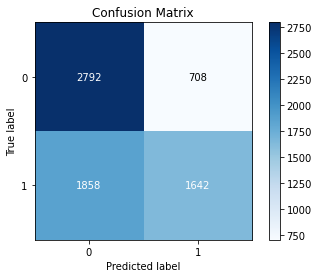

In [ ]:
#print('Accuracy on test:', lstm_score[1])
model_evaluation_plt(modelE_LSTM_1, test_X_, test)

In [ ]:
#predicts=lstm_best_model_final.predict(test_X)
res = lstm_best_finalE.predict(test_X_)

In [ ]:
lstm_best_finalE.save('/content/drive/MyDrive/Yan/saved_model/lstm_best_finalE')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yan/saved_model/lstm_best_finalE/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Yan/saved_model/lstm_best_finalE/assets


In [ ]:
modelE_LSTM_1 = tf.keras.models.load_model('/content/drive/MyDrive/Yan/saved_model/lstm_best_finalE')

#predictions=predicts.argmax(1)

# data_cleaning_word2vec

In [ ]:
import nltk, os, gensim
import numpy as np
import pandas as pd

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
evidence_trainDF = pd.read_csv("/content/drive/MyDrive/Yan/IBMDebaterEvidenceSentences 3/test.csv")
evidence_trainDF[:1].T

,0
topic,We should limit the Internet of things
the concept of the topic,the Internet of things
candidate,"In an ambient intelligence world, devices work..."
candidate masked,"In an ambient intelligence world, devices work..."
label,0
wikipedia article name,Ambient intelligence
wikipedia url,https://en.wikipedia.org/wiki/Ambient_intellig...


In [ ]:
train_text = evidence_trainDF[['topic' , 'candidate' ,'label' ]]

In [ ]:
evidence_testDF = pd.read_excel("/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/2014_7_18_ibm_CDE(1)data.xlsx")
evidence_testDF[:1].T

,0
Topic,the sale of violent video games to minors
Article,Video_game_controversies
Claim,exposure to violent video games causes at leas...
CDE,The most recent large scale meta-anlysis-- exa...
Type 1,STUDY
Type 2,NaN
Unnamed: 6,NaN


In [ ]:
with open('/content/drive/MyDrive/Yan/IBM_Debater_(R)_CE-ACL-2014.v0/wiki12_articles/2007_Burmese_anti-government_protests') as f:
    test_text = f.read()
    print (test[418: 568])

In [ ]:
# functions from https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [ ]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found out {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model


w2vec = get_word2vec(MySentences([test_text]), '/content/drive/MyDrive/Yan/w2vmodel')

Found out /content/drive/MyDrive/Yan/w2vmodel


In [ ]:
w2vec = get_word2vec(MySentences([train_text]), '/content/drive/MyDrive/Yan/w2vmodel')

Found out /content/drive/MyDrive/Yan/w2vmodel
